In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
import FinanceDataReader as fdr
from datetime import datetime

In [3]:
from alpha_code_1 import get_alpha

In [82]:
start_date = '2001-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df = get_alpha(df)

# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 2. 정규화 (표준화: 평균 0, 표준편차 1)
def normalize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index, columns=df.columns)

# 3. 이산형 / 연속형 분리
def separate_discrete_continuous(df, threshold=10):
    discrete_features = []
    continuous_features = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values <= threshold:
            discrete_features.append(col)
        else:
            continuous_features.append(col)
    return discrete_features, continuous_features

# 4. 중복 feature 제거 (feature 값이 거의 비슷한 경우 제거)
def remove_duplicate_features(df, duplicate_threshold=0.2):
    to_remove = []
    for col in df.columns:
        freq = df[col].value_counts(normalize=True).max()
        if freq > duplicate_threshold:
            to_remove.append(col)
    df_cleaned = df.drop(columns=to_remove)
    return df_cleaned, to_remove


# 5. 전체 파이프라인 함수
def clean_features(df):
    print("원본 feature 수:", df.shape[1])

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    # 이산형/연속형 분리
    discrete_features, continuous_features = separate_discrete_continuous(df)
    print(f"이산형 feature 수: {len(discrete_features)}, 연속형 feature 수: {len(continuous_features)}")

    # 중복 feature 제거
    df_cleaned, removed_features = remove_duplicate_features(df)
    print(f"중복 feature 제거 완료 (제거한 feature 수: {len(removed_features)})")

    print("최종 feature 수:", df_cleaned.shape[1])
    return df_cleaned, discrete_features, continuous_features, removed_features

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas_only = df[alpha_cols]

# 파이프라인 적용
df_cleaned, discrete_features, continuous_features, removed_features = clean_features(df_alphas_only)

# 1. 상관 높은 feature 제거 함수
def remove_highly_correlated_features(df, correlation_threshold=0.99):
    corr_matrix = df.corr().abs()  # 절댓값 상관계수 계산
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned, to_drop

# 1. 상관 높은 feature 제거
df_uncorrelated, dropped_corr_features = remove_highly_correlated_features(df_cleaned, correlation_threshold=0.99)

print(f"상관 관계로 제거한 feature 수: {len(dropped_corr_features)}")

c:\Users\minju\OneDrive\바탕 화면\다트비\캐금스\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)


원본 feature 수: 82
결측값 채우기 완료
정규화 완료
이산형 feature 수: 16, 연속형 feature 수: 66
중복 feature 제거 완료 (제거한 feature 수: 23)
최종 feature 수: 59
상관 관계로 제거한 feature 수: 0


c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1066: RuntimeWarning: overflow encountered in square
  temp **= 2
c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\minju\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\minju\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:86: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


In [95]:
# 2. 40개 feature 최종 선택 (분산 큰 순서대로)
def select_top_variance_features(df, top_k):
    variances = df.var().sort_values(ascending=False)
    selected_features = variances.head(top_k).index.tolist()
    df_selected = df[selected_features]
    return df_selected, selected_features

# 2. 40개 feature 최종 선정
df_selected, selected_features = select_top_variance_features(df_uncorrelated, top_k=58)

print(f"최종 선택된 k개 feature 이름들:")
print(selected_features)
df_selected['target'] = df['UpDown'].shift(-1)
df_selected['target'] = df_selected['target'].replace(3, 2)
df_selected['target'] = df_selected['target'].replace(1, 0)
df_selected['target'] = df_selected['target'].replace(2, 1)

df_selected = df_selected.dropna()
X = df_selected.drop(columns=['target'])
y = df_selected['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

최종 선택된 k개 feature 이름들:
['alpha043', 'alpha033', 'alpha077', 'alpha026', 'alpha037', 'alpha042', 'alpha014', 'alpha038', 'alpha041', 'alpha005', 'alpha008', 'alpha028', 'alpha018', 'alpha050', 'alpha006', 'alpha044', 'alpha030', 'alpha078', 'alpha012', 'alpha020', 'alpha083', 'alpha017', 'alpha085', 'alpha098', 'alpha072', 'alpha032', 'alpha016', 'alpha022', 'alpha039', 'alpha011', 'alpha057', 'alpha013', 'alpha055', 'alpha010', 'alpha029', 'alpha036', 'alpha101', 'alpha035', 'alpha019', 'alpha003', 'alpha015', 'alpha031', 'alpha002', 'alpha066', 'alpha024', 'alpha009', 'alpha053', 'alpha094', 'alpha088', 'alpha045', 'alpha040', 'alpha060', 'alpha034', 'alpha047', 'alpha052', 'alpha025', 'alpha071', 'alpha073']


In [96]:
model = LogisticRegression(
    penalty='l2',
    C=1.0,  # 처음은 1.0로 시작, 튜닝할 때 0.1이나 10도 테스트
    solver='lbfgs',
    class_weight=None,
    max_iter=1000,
    random_state=42
)

model.fit(X_train,y_train)

#Predicting train and test set result
y_train_pred2 = model.predict(X_train)
y_test_pred2 = model.predict(X_test)

print("🔍 Classification Report:\n", classification_report(y_test, y_test_pred2))

print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")

🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.47      0.51       552
         1.0       0.44      0.52      0.48       437

    accuracy                           0.49       989
   macro avg       0.49      0.49      0.49       989
weighted avg       0.50      0.49      0.49       989

Train Accuracy: 0.5611
Test Accuracy: 0.4914


In [97]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=model, n_features_to_select=10)  # 최종적으로 20개 feature를 남기고 싶다면

# 3. RFE 실행 (fit)
rfe.fit(X_train, y_train)

# 4. 선택된 feature 확인
selected_features = X_train.columns[rfe.support_]
print(selected_features)

Index(['alpha028', 'alpha018', 'alpha006', 'alpha035', 'alpha003', 'alpha015',
       'alpha088', 'alpha060', 'alpha047', 'alpha025'],
      dtype='object')


In [103]:
X = df_selected[selected_features]
y = df_selected['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = LogisticRegression(
    penalty='l2',
    C=0.01,  # 처음은 1.0로 시작, 튜닝할 때 0.1이나 10도 테스트
    solver='liblinear',
    class_weight=None,
    max_iter=500,
    random_state=42
)

model.fit(X_train,y_train)

#Predicting train and test set result
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("🔍 Classification Report:\n", classification_report(y_test, y_test_pred))

print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")

🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.55      0.55       552
         1.0       0.44      0.45      0.45       437

    accuracy                           0.51       989
   macro avg       0.50      0.50      0.50       989
weighted avg       0.51      0.51      0.51       989

Train Accuracy: 0.5403
Test Accuracy: 0.5066


In [100]:
# 모델의 coefficients
coefficients = model.coef_[0]  # (이진 분류면 1차원 배열)

# feature names
feature_names = X.columns

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# 영향력 큰 순서대로 정렬
importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

print(importance_df)


    feature  coefficient  abs_coefficient
2  alpha006     0.230214         0.230214
4  alpha003    -0.228257         0.228257
0  alpha028    -0.174777         0.174777
6  alpha088     0.149715         0.149715
1  alpha018     0.123079         0.123079
7  alpha060     0.122658         0.122658
9  alpha025     0.119855         0.119855
8  alpha047    -0.116210         0.116210
3  alpha035     0.109626         0.109626
5  alpha015     0.098532         0.098532


In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

param_grid = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced', None],
        'max_iter': [500, 1000]
    },
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced', None],
        'max_iter': [500, 1000]
    }
]
# 사용할 평가 지표들
scoring_metrics = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc'  # 미리 정의된 스코어
}

# 결과 저장용
results_summary = {}

# 반복 실행: 각 scoring에 대해 GridSearchCV 수행
for metric_name, scorer in scoring_metrics.items():
    print(f"\n🔍 GridSearchCV (scoring = {metric_name})")
    
    grid = GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid,
        cv=5,
        scoring=scorer,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    print("최적 하이퍼파라미터:", grid.best_params_)
    print(f"최고 {metric_name} 점수: {grid.best_score_:.4f}")
    
    # 결과 저장
    results_summary[metric_name] = {
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
    }


🔍 GridSearchCV (scoring = f1)
최적 하이퍼파라미터: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
최고 f1 점수: 0.4271

🔍 GridSearchCV (scoring = precision)
최적 하이퍼파라미터: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
최고 precision 점수: 0.5137

🔍 GridSearchCV (scoring = recall)
최적 하이퍼파라미터: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
최고 recall 점수: 0.5060

🔍 GridSearchCV (scoring = roc_auc)
최적 하이퍼파라미터: {'C': 0.01, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
최고 roc_auc 점수: 0.5346


Threshold=0.500 | Precision(1)=0.443 | Recall(1)=0.453 | Precision(0)=0.559 | Recall(0)=0.549 | Accuracy=0.507
Threshold=0.501 | Precision(1)=0.444 | Recall(1)=0.437 | Precision(0)=0.560 | Recall(0)=0.567 | Accuracy=0.510
Threshold=0.502 | Precision(1)=0.446 | Recall(1)=0.426 | Precision(0)=0.561 | Recall(0)=0.582 | Accuracy=0.513
Threshold=0.503 | Precision(1)=0.448 | Recall(1)=0.416 | Precision(0)=0.563 | Recall(0)=0.594 | Accuracy=0.516
Threshold=0.504 | Precision(1)=0.451 | Recall(1)=0.410 | Precision(0)=0.564 | Recall(0)=0.605 | Accuracy=0.519
Threshold=0.505 | Precision(1)=0.453 | Recall(1)=0.398 | Precision(0)=0.565 | Recall(0)=0.620 | Accuracy=0.522
Threshold=0.506 | Precision(1)=0.459 | Recall(1)=0.387 | Precision(0)=0.568 | Recall(0)=0.639 | Accuracy=0.528
Threshold=0.507 | Precision(1)=0.460 | Recall(1)=0.378 | Precision(0)=0.568 | Recall(0)=0.649 | Accuracy=0.529
Threshold=0.508 | Precision(1)=0.453 | Recall(1)=0.364 | Precision(0)=0.564 | Recall(0)=0.652 | Accuracy=0.525
T

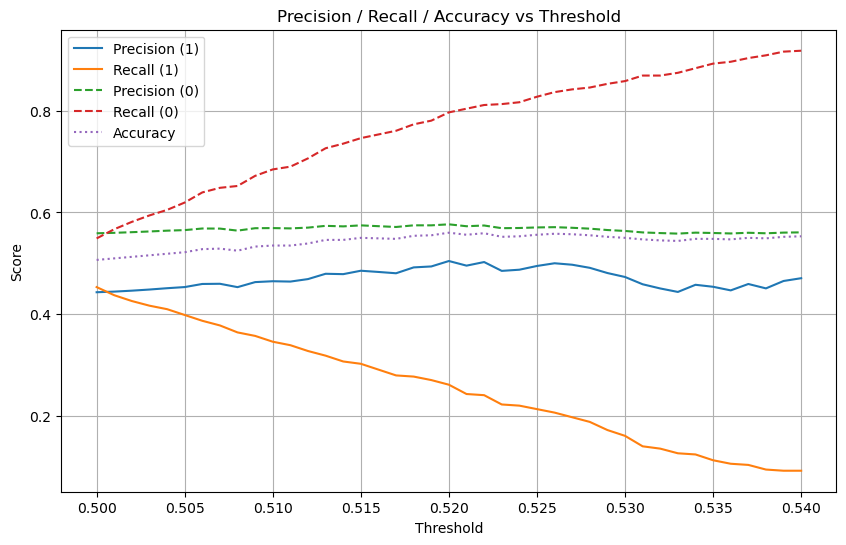

In [106]:
# 1. 확률 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. threshold 리스트
thresholds = np.arange(0.5, 0.54, 0.001)

# 3. 저장할 리스트
precision_1_list = []
recall_1_list = []
precision_0_list = []
recall_0_list = []
accuracy_list = []

# 4. 각 threshold에 대해 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
    recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
    precision_0 = precision_score(y_test, y_pred_custom, pos_label=0)
    recall_0 = recall_score(y_test, y_pred_custom, pos_label=0)
    accuracy = accuracy_score(y_test, y_pred_custom)

    precision_1_list.append(precision_1)
    recall_1_list.append(recall_1)
    precision_0_list.append(precision_0)
    recall_0_list.append(recall_0)
    accuracy_list.append(accuracy)

# 5. 결과 출력
for t, p1, r1, p0, r0, acc in zip(thresholds, precision_1_list, recall_1_list, precision_0_list, recall_0_list, accuracy_list):
    print(f"Threshold={t:.3f} | Precision(1)={p1:.3f} | Recall(1)={r1:.3f} | Precision(0)={p0:.3f} | Recall(0)={r0:.3f} | Accuracy={acc:.3f}")

# 6. 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_1_list, label='Precision (1)', linestyle='-')
plt.plot(thresholds, recall_1_list, label='Recall (1)', linestyle='-')
plt.plot(thresholds, precision_0_list, label='Precision (0)', linestyle='--')
plt.plot(thresholds, recall_0_list, label='Recall (0)', linestyle='--')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

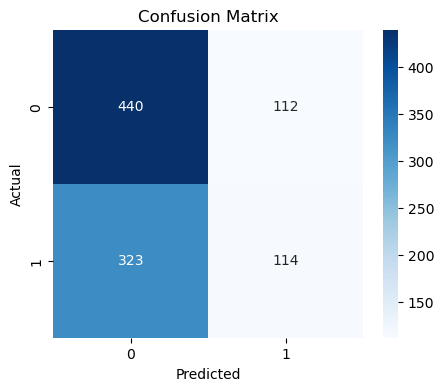

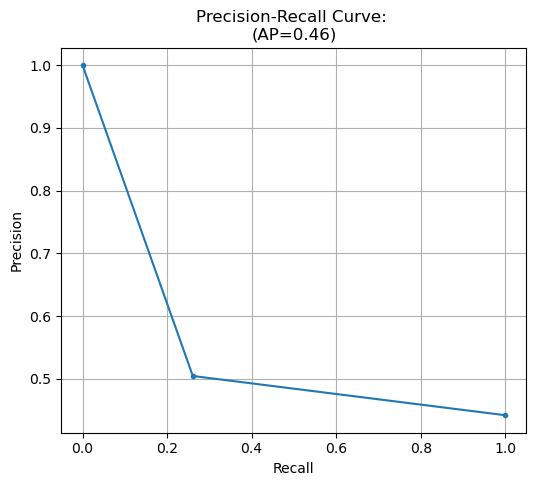

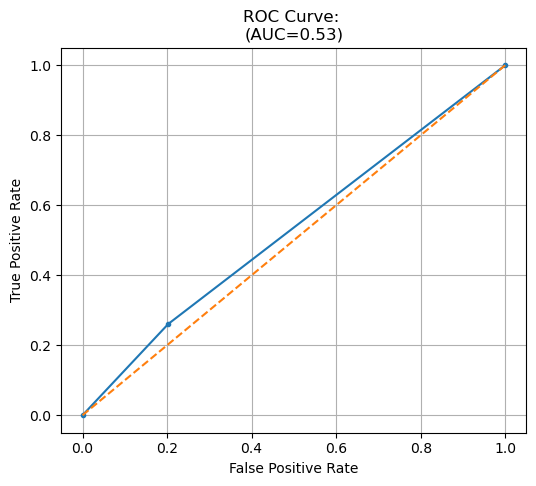


✅ Final Test Accuracy (Threshold = 0.52): 0.5602


In [107]:
#성과 분석 시각화
threshold = 0.52
y_scores = (y_pred_proba >= threshold).astype(int)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_scores)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve 시각화
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve: \n(AP={average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve: \n(AUC={roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 5. 최종 Accuracy 출력
final_accuracy = accuracy_score(y_test, y_scores)
print(f"\n✅ Final Test Accuracy (Threshold = {threshold}): {final_accuracy:.4f}")

In [110]:
start_date_actual = '2021-01-01'
end_date_actual = '2021-12-31'

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual)
df_actual = df_actual.reset_index()

df_actual = df_actual.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df_actual = get_alpha(df_actual)
features = X.columns.tolist()
df_actual = df_actual[features]

# 5. 전체 파이프라인 함수
def select_features(df):

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    return df

# 파이프라인 적용
df_selected_actual = select_features(df_actual)

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual).reset_index()
df_selected_actual['target'] = df_actual['UpDown'].shift(-1)
df_selected_actual['target'] = df_selected_actual['target'].replace(3, 2)
df_selected_actual['target'] = df_selected_actual['target'].replace(1, 0)
df_selected_actual['target'] = df_selected_actual['target'].replace(2, 1)

df_selected_actual = df_selected_actual.dropna()

X_actual = df_selected_actual.drop(columns=['target'])
y_actual = df_selected_actual['target']
y_actual_pred = model.predict(X_actual)

y_pred_proba = model.predict_proba(X_actual)[:, 1]

# 2. 임의 threshold 적용
threshold = 0.52  # 예: 0.6 이상일 때만 1로 분류
y_pred_custom = (y_pred_proba >= threshold).astype(int)

print("🔍 Classification Report:\n", classification_report(y_actual, y_pred_custom))

c:\Users\minju\OneDrive\바탕 화면\다트비\캐금스\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)


결측값 채우기 완료
정규화 완료
🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.92      0.66       127
         1.0       0.50      0.08      0.14       120

    accuracy                           0.51       247
   macro avg       0.51      0.50      0.40       247
weighted avg       0.51      0.51      0.41       247

